In [7]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [8]:
def ret2price(ret):
    price = np.ones(len(ret))
    for i in range(1, len(ret)):
        price[i] = ret[i]*price[i-1]
    return price
def price2ret(price):
    ret = np.ones(len(price))
    for i in range(1, len(ret)):
        ret[i] = price[i]/price[i-1]
    return ret
def calculate_transaction_costs(change_in_positions, cost_per_trade):
    return np.sum(np.abs(change_in_positions)) * cost_per_trade

Here we Import the test set and apply a monthly resempling as in the train/validation case

In [9]:
# Load the dataset
#this is the dataset dor the test set
data = pd.read_excel('InvestmentReplica2.xlsx', sheet_name='Test')  

data.set_index('Date', inplace=True);
monthly_prices = data.resample('M').last()

# Define the target variable as a linea r combination of 'HFRXGL', 'MXWO', and 'LEGATRUU'
data['Target'] =  0.25 * data['HFRXGL'] + 0.5 * data['MXWO'] + 0.25 * data['LEGATRUU']
monthly_prices['Target'] = 0.25 * monthly_prices['HFRXGL'] + 0.5 * monthly_prices['MXWO'] + 0.25 * monthly_prices['LEGATRUU']


# Compute returns for all columns
returns = data.pct_change()+1
returns = returns.fillna(0)

returns_monthly = monthly_prices.pct_change()+1
returns_monthly = returns_monthly.fillna(0)


# Define features (predictors) and target variable
features = returns.columns.drop(['HFRXGL', 'MXWO', 'LEGATRUU','MXWD','Target'])  # Exclude the target variable and other columns
target = 'Target'

features_monthly = returns_monthly.columns.drop(['HFRXGL', 'MXWO', 'LEGATRUU','MXWD','Target'])  # Exclude the target variable and other columns
target = 'Target'

X = returns[features].values  # Convert to numpy array
y = returns[target].values  # Convert to numpy array

X_month=returns_monthly[features].values
y_month=returns_monthly[target].values


We use the same validation set optimized lasso parameter in our test set and plot the results

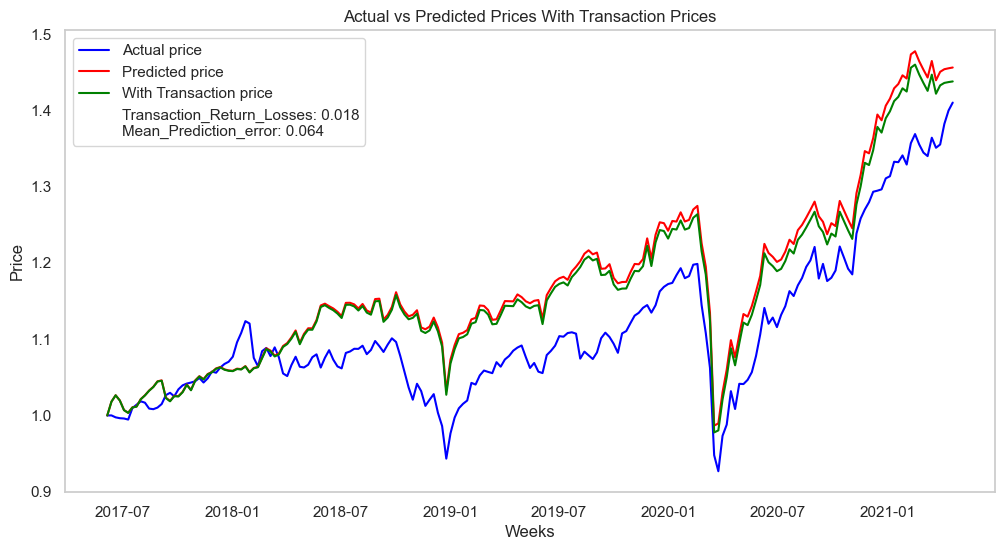

In [10]:
actual_return = []
predicted_return = []
portfolio_weights=[]
window_size = 24
for start in range(len(returns) - window_size):
    end = start + window_size
    X_train, X_test = X[start:end-1], X[end-1:end+1]
    y_train, y_test = y[start:end-1], y[end-1:end+1]

    # Initialize and fit the model
    model = Lasso(alpha=1e-8,fit_intercept=False,tol=1e-4,max_iter=100000)
    model.fit(X_train, y_train)

    portfolio_weights.append(model.coef_)
    # Predict the next week
    y_pred = model.predict(X_test)
    # Store actual and predicted prices for plotting
    actual_return.append(y_test[1])
    predicted_return.append(y_pred[1])        
    actual_price=ret2price(actual_return)
    predicted_price=ret2price(predicted_return)


    weight_changes = abs(np.diff(portfolio_weights, axis=0))
    cost_per_unit = 0.0005  # example cost
    adjusted_portfolio_prices = [actual_price[0]]
    for i in range(len(weight_changes)):
        transaction_cost = calculate_transaction_costs(weight_changes[i], cost_per_unit)
        # Adjust the portfolio price by subtracting the transaction costs
        adjusted_price = adjusted_portfolio_prices[-1] * (predicted_return[i+1]) - transaction_cost
        adjusted_portfolio_prices.append(adjusted_price)

# Plot the actual vs predicted prices

plt.figure(figsize=(12, 6))
plt.plot(data.index[24:],actual_price, label='Actual price', color='blue')
plt.plot(data.index[24:],predicted_price, label='Predicted price', color='red')
plt.plot(data.index[24:],adjusted_portfolio_prices, label='With Transaction price', color='Green')

Transaction_losses=predicted_price[-1]-adjusted_portfolio_prices[-1]

Mean_Prediction_error=np.mean(np.abs(predicted_price-actual_price))

extra_legend_labels = [
    f'Transaction_Return_Losses: {Transaction_losses:.3f}\n'
    f'Mean_Prediction_error: {Mean_Prediction_error:.3f}'
    ]

# Add dummy plots for the extra legend entries
plt.plot([], [], ' ', label=extra_legend_labels[0])

plt.title('Actual vs Predicted Prices With Transaction Prices')
plt.xlabel('Weeks')
plt.ylabel('Price')
plt.grid(None)
plt.legend()
plt.show()

We are managing to track better than in the validation set as suggested by the lower mean prediction error (0.064 vs 0.11), suggesting that out model actually generalizes pretty well.

We compute the 1 month 99% VAR of our portfolio using historical realized losses.

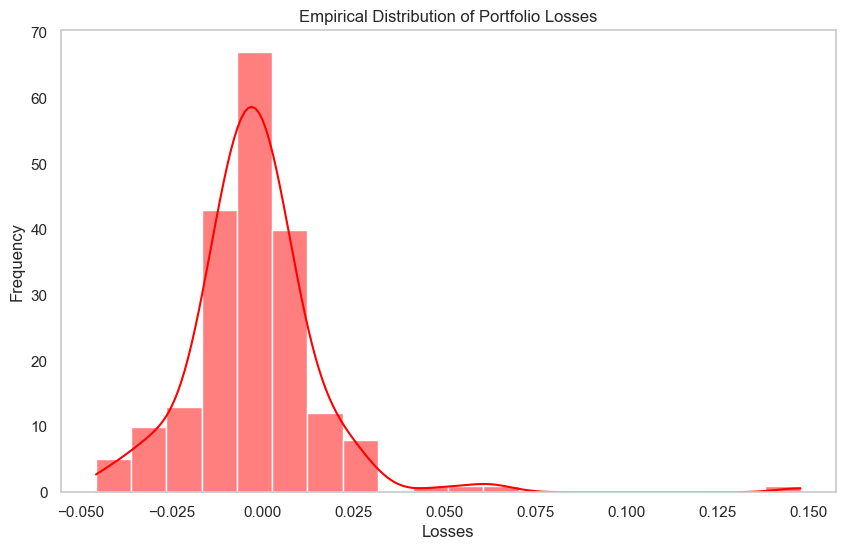

Value at Risk (VaR) at 99% confidence level: -0.08


In [11]:
#Calculate VAR for Weekly portfolio
sns.set(style="whitegrid")
Losses=-np.diff(predicted_price)
# Plotting the histogram with a kernel density estimate
plt.figure(figsize=(10, 6))
sns.histplot(Losses, bins=20, kde=True, color='red')
plt.title('Empirical Distribution of Portfolio Losses')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.grid(visible = None)
plt.show()
VaR_99 = np.percentile(Losses, 1)*2  # since losses are negative, the 5th percentile corresponds to the 95th from a loss perspective
print("Value at Risk (VaR) at 99% confidence level: {:.2f}".format(VaR_99))

Above we computed the historical 1 month VaR at 99%. We are around the 0.1 return loss at 99%. So we are within the MIFID regulation which imposes a maximum 1M VaR at 99% confidence of 20% of the invested capital.

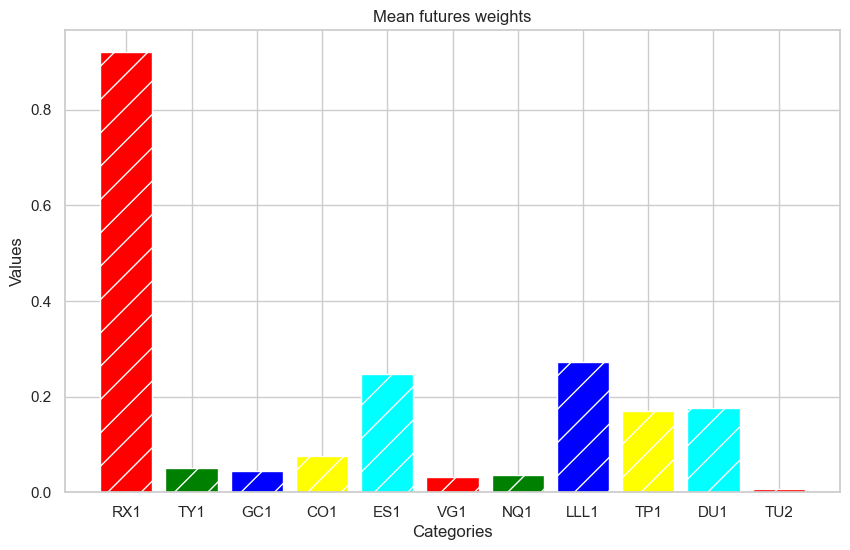

In [12]:
values=np.mean(np.abs(portfolio_weights),axis=0)
plt.figure(figsize=(10, 6))
plt.bar(range(len(values)),values, color=['red', 'green', 'blue', 'yellow', 'cyan'], hatch='/')
plt.xticks(range(len(values)), features) 
plt.title('Mean futures weights')
plt.xlabel('Categories')
plt.ylabel('Values')
plt.grid(True)
plt.show()

The above is a plot of the mean absolute value of the portfolio position on each asset over time, this is to get a general overview of what assets seems to be the most chosen by the algorithm. We observe that the L1 penalty seems to have severally reduced the impact of some of the assets. The only one that seem to be somewhat relevant are:

RX1 = Bund (10 Yrs Ger)

DU1 = Schatz (2yrs Gvt Ger)

ES1 = S&P 500 ( US Equity)

LLL1 = MSCI Emerging Markets (EM Equity)

TP1 = Topix (Jap. Equity)

As we can see, we don't seem to be investing in both US and Germany bonds, which is consistent with the fact that lasso penalty is trying to avoid using simultaneously very correlated assets.


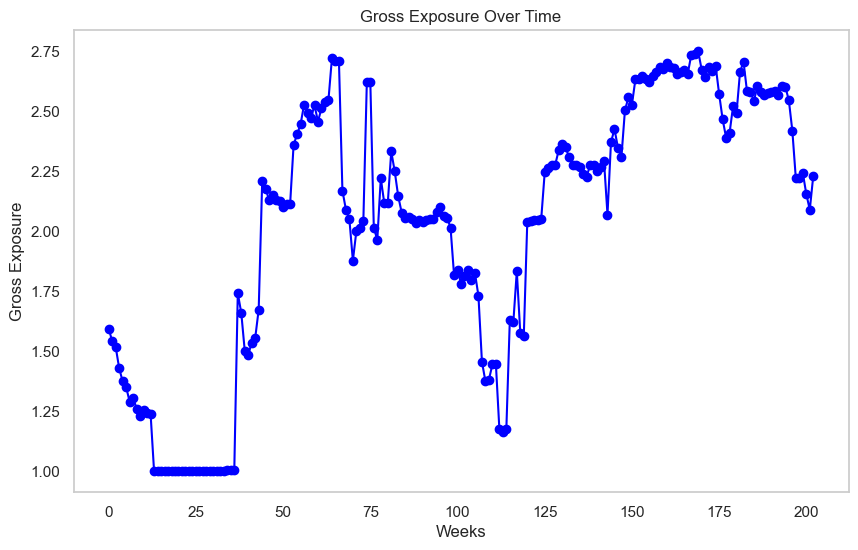

In [13]:
plt.figure(figsize=(10, 6))
values=np.sum(np.abs(portfolio_weights),axis=1)
plt.plot(values,marker='o', linestyle='-', color='blue')
# Adding title and labels
plt.title('Gross Exposure Over Time')
plt.xlabel('Weeks')
plt.ylabel('Gross Exposure')
plt.grid(visible = None)

Above is a plot of our gross exposure over the weeks, it seems that our algorithm leads to high variance in the exposure especially in a period where there have been big market movements, maybe using a monthly rebalancing we can observe a more steady level of exposure.
Also, the rapid changes in exposure explain the huge transaction costs we incurred.

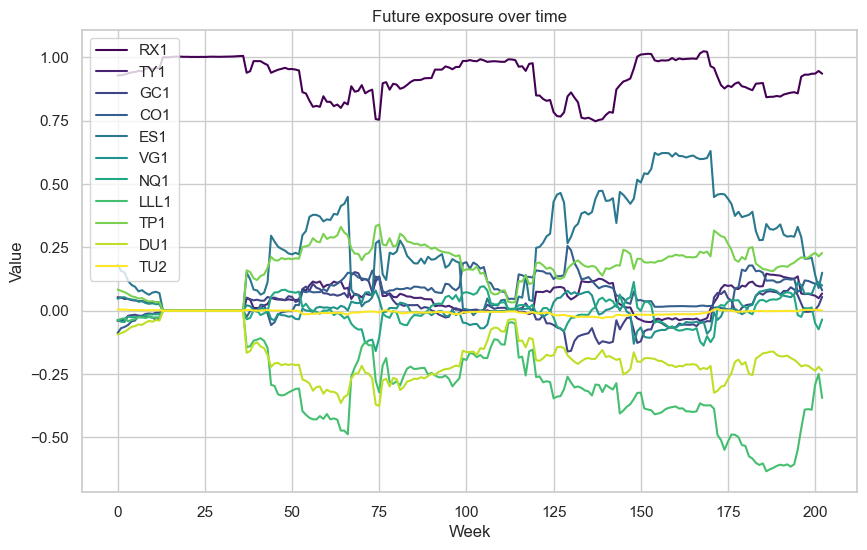

In [8]:
# Example matrix with 4 columns and 10 rows
matrix = np.array(portfolio_weights)  # Random data

# Create the plot
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, matrix.shape[1]))  # Generate distinct colors

# Plot each column
for i in range(matrix.shape[1]):
    plt.plot(matrix[:, i], linestyle='-', color=colors[i], label=features[i])

# Adding title and labels
plt.title('Future exposure over time')
plt.xlabel('Week')
plt.ylabel('Value')

# Adding legend
plt.legend()

# Show grid
plt.grid(True)

# Display the plot
plt.show()

Here we have a plot of the evolution of the futures exposure of our algorithm over time.
We keep a steady exposure to deutsche 10 year bond future. While others are discarded by our algorithm quite consistently. We can observe that there are periods in which we basically keep only the exposure to RX1

Now we go to the monthly rebalancing test set

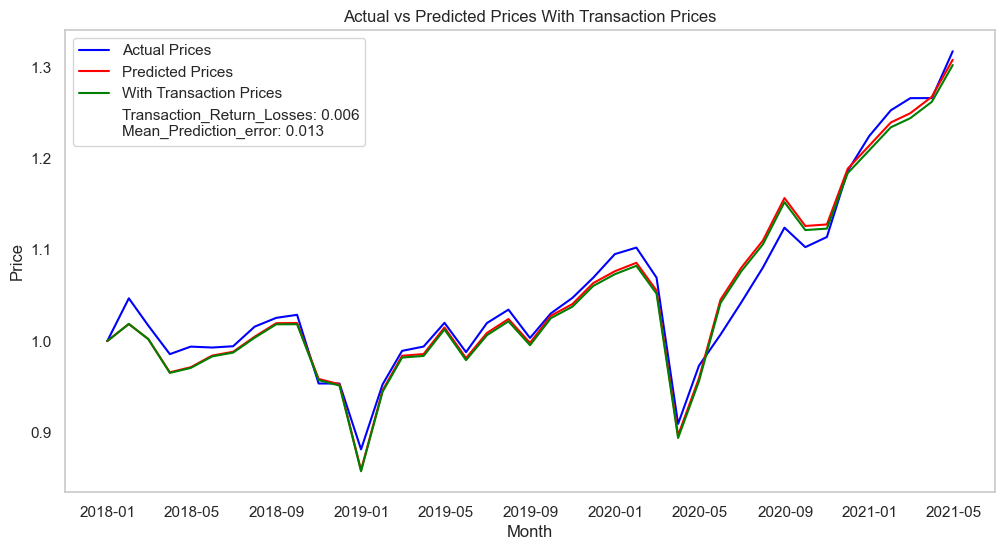

In [9]:
actual_return = []
predicted_return = []
portfolio_weights=[]
window_size = 12
for start in range(len(returns_monthly) - window_size):
    end = start + window_size
    X_train, X_test = X_month[start:end-1], X_month[end-1:end+1]
    y_train, y_test = y_month[start:end-1], y_month[end-1:end+1]
        # Initialize and fit the model
    model = Lasso(alpha=5*1e-5,fit_intercept=False,tol=1e-4,max_iter=100000)
    model.fit(X_train, y_train)

    portfolio_weights.append(model.coef_)
        # Predict the next week
    y_pred = model.predict(X_test)

        # Store actual and predicted prices for plotting
    actual_return.append(y_test[1])
    predicted_return.append(y_pred[1])        
    actual_price=ret2price(actual_return)
    predicted_price=ret2price(predicted_return)


    weight_changes = abs(np.diff(portfolio_weights, axis=0))
    cost_per_unit = 0.0005  # example cost
    adjusted_portfolio_prices = [actual_price[0]]
    for i in range(len(weight_changes)):
        transaction_cost = calculate_transaction_costs(weight_changes[i], cost_per_unit)
        # Adjust the portfolio price by subtracting the transaction costs
        adjusted_price = adjusted_portfolio_prices[-1] * (predicted_return[i+1]) - transaction_cost
        adjusted_portfolio_prices.append(adjusted_price)
#print(transaction_cost)
# Plot the actual vs predicted prices

plt.figure(figsize=(12, 6))
plt.plot(returns_monthly.index[12:],actual_price, label='Actual Prices', color='blue')
plt.plot(returns_monthly.index[12:],predicted_price, label='Predicted Prices', color='red')
plt.plot(returns_monthly.index[12:],adjusted_portfolio_prices, label='With Transaction Prices', color='Green')

Transaction_losses=predicted_price[-1]-adjusted_portfolio_prices[-1]

Mean_Prediction_error=np.mean(np.abs(predicted_price-actual_price))

extra_legend_labels = [
    f'Transaction_Return_Losses: {Transaction_losses:.3f}\n'
    f'Mean_Prediction_error: {Mean_Prediction_error:.3f}'
    ]

# Add dummy plots for the extra legend entries
plt.plot([], [], ' ', label=extra_legend_labels[0])


plt.title('Actual vs Predicted Prices With Transaction Prices')
plt.xlabel('Month')
plt.ylabel('Price')
plt.legend()
plt.grid(visible = None)
plt.show()

Consistently with the results we observed in the validation set, we are managing to pay way less transaction fees in the monthly rebalancing case (only 0.006 vs 0.018)

Also we are obtaining a better tracking error compared to both the validation set (in the monthly case 0.013 vs 0.03 ) and the test set (in the weekly case 0.013 vs 0.064).

We can confidently conclude that for a lasso regression tracking algorithm for these kinds of indexes a monthly rebalancing performs better.

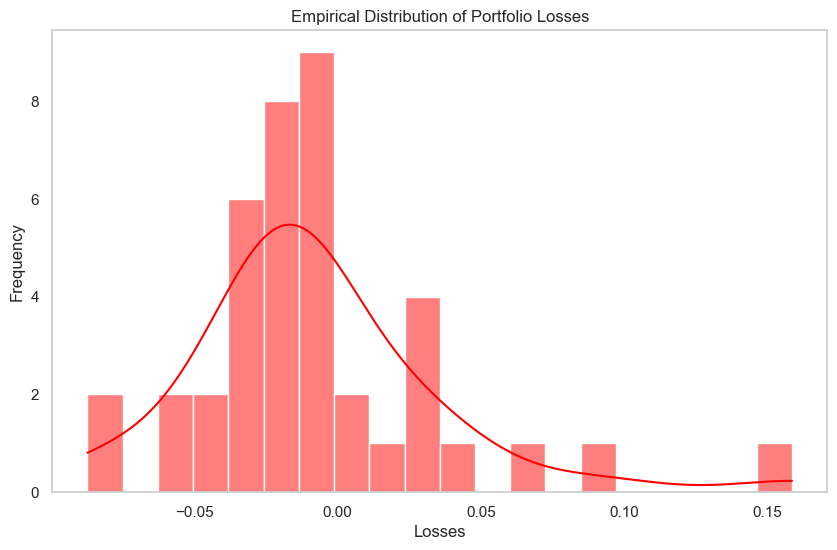

Value at Risk (VaR) at 99% confidence level: -0.09


In [10]:
#Calculate VAR for Weekly portfolio
sns.set(style="whitegrid")
Losses=-np.diff(predicted_price)
# Plotting the histogram with a kernel density estimate
plt.figure(figsize=(10, 6))
sns.histplot(Losses, bins=20, kde=True, color='red')
plt.title('Empirical Distribution of Portfolio Losses')
plt.xlabel('Losses')
plt.ylabel('Frequency')
plt.grid(visible = None)
plt.show()
VaR_99 = np.percentile(Losses, 1)  # since losses are negative, the 5th percentile corresponds to the 95th from a loss perspective
print("Value at Risk (VaR) at 99% confidence level: {:.2f}".format(VaR_99))

Again, computing out VaR we are by far within the MiFid regulation. Although our estimate in this case is expected to be way less reliable and precise, since we are dealing with a smaller dataset (only monthly data from 2018-01 to 2021-05)

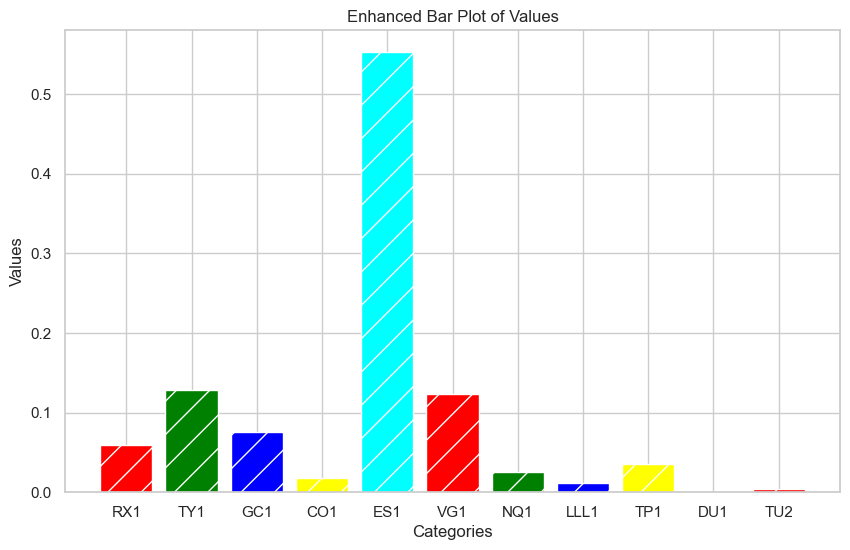

In [11]:
values=np.mean(np.abs(portfolio_weights),axis=0)
plt.figure(figsize=(10, 6))
plt.bar(range(len(values)),values, color=['red', 'green', 'blue', 'yellow', 'cyan'], hatch='/')
plt.title('Enhanced Bar Plot of Values')
plt.xlabel('Categories')
plt.xticks(range(len(values)), features) 
plt.ylabel('Values')
plt.grid(True)
plt.show()

The asset allocation is different with respect to the weekly case, here we invest mainly in the S&P500 future (ES1) and in minor part Eurostoxx 50 future (VG1), the Bund future exposure is drastically lower, but we have increased the US 10y Bond position.
Overall we have increased our exposure to equity and reduced on bonds. 

RX1 = Bund (10 Yrs Ger)

TY1 = 10Yrs US Treasury (US Gvt)

GC1 = Gold

ES1 = S&P 500 ( US Equity)

VG1 = Eurostoxx 50 (EU equity)


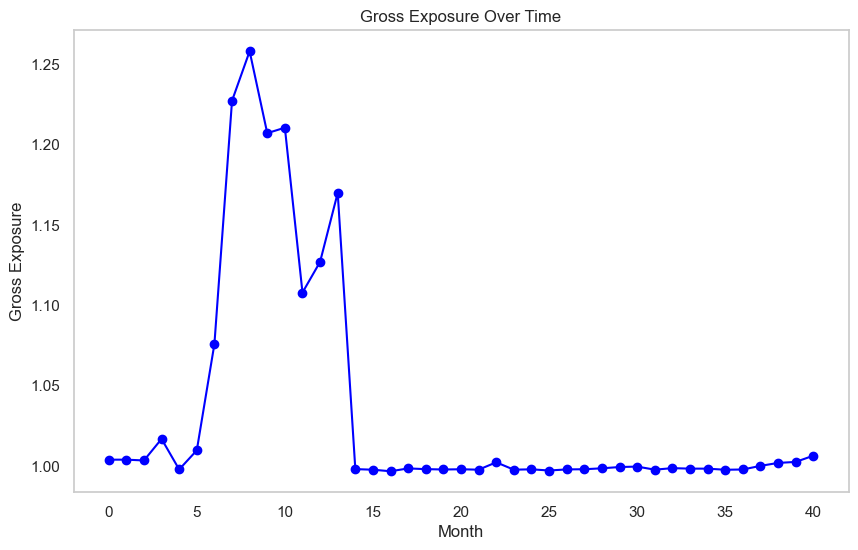

In [12]:
plt.figure(figsize=(10, 6))
values=np.sum(np.abs(portfolio_weights),axis=1)
plt.plot(values,marker='o', linestyle='-', color='blue')
# Adding title and labels
plt.title('Gross Exposure Over Time')
plt.xlabel('Month')
plt.ylabel('Gross Exposure')
plt.grid(visible = None)

We have a lower exposure wrt the weekly case and this is consistent with the idea that monthly rebalancing allows for a "smoother ride" avoiding overreacting to every market movement. 

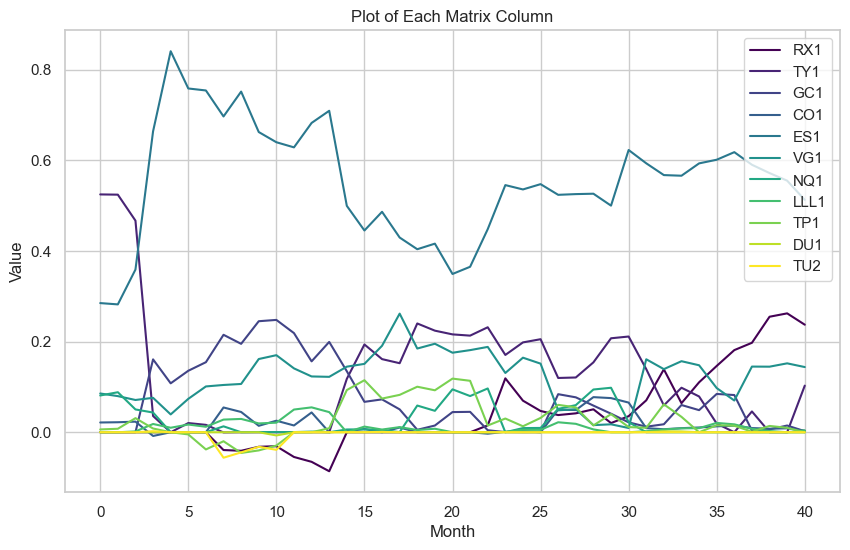

In [13]:
# Example matrix with 4 columns and 10 rows
matrix = np.array(portfolio_weights)  # Random data

# Create the plot
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, matrix.shape[1]))  # Generate distinct colors

# Plot each column
for i in range(matrix.shape[1]):
    plt.plot(matrix[:, i], linestyle='-', color=colors[i], label=features[i])

# Adding title and labels
plt.title('Plot of Each Matrix Column')
plt.xlabel('Month')
plt.ylabel('Value')

# Adding legend
plt.legend()

# Show grid
plt.grid(True)

# Display the plot
plt.show()

We see that our exposures on futures don't vary abruptly over time.
We keep predominant our exposure on the S&P500 future for the whole period, instead some futures are always kept at almost zero exposure; all this is very useful for reducing transaction cost.  